In [1]:
# Libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import collections
import requests

from matplotlib.pyplot import figure
from matplotlib import cm
from statistics import mean
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import svm  
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier  

# Read dataset
df = pd.read_csv('dataset.csv')

In [2]:
df.head(2)

,track,artist,lyrics,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,rip-van-winkle,the-casket-lottery,I lie awake after 20 years of sleep. learn to ...,0.8120,0.687,184093,0.325,0.0,1,0.3570,-9.192,1,0.0356,133.543,4,0.779,Rock
1,wings-off-flies,cave-nick,"She loves me, she loves me not\nShe loves me, ...",0.0845,0.494,246653,0.424,0.0,4,0.0833,-12.310,0,0.1310,69.741,4,0.277,Rock


In [3]:
features_df = df.drop(["track", "artist", "lyrics"], axis=1)

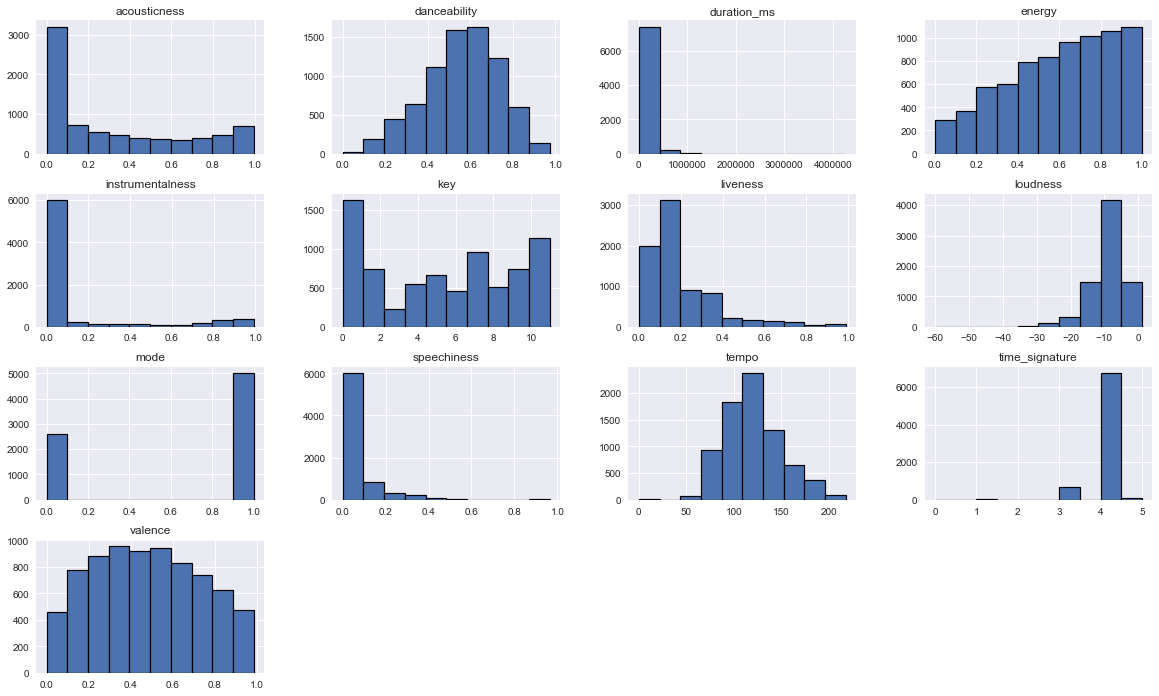

In [4]:
# Checking distribution
# We find that some of the features are almost normally distributed: danceability, liveness (skewed), tempo, valence

features_df.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [5]:
# Normalising data
# Several algorithms can sometimes converge far faster on normalized data so we will predict using this data
# and compare accuracy with not normalized data

x = features_df.drop("genre", axis=1).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features_df_norm = pd.DataFrame(x_scaled, columns = np.delete(features_df.columns.values, -1))

In [6]:
features_df_norm["genre"] = features_df["genre"]

In [7]:
features_df.head(2)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0.8120,0.687,184093,0.325,0.0,1,0.3570,-9.192,1,0.0356,133.543,4,0.779,Rock
1,0.0845,0.494,246653,0.424,0.0,4,0.0833,-12.310,0,0.1310,69.741,4,0.277,Rock


In [8]:
features_df_norm.head(2)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0.815261,0.705339,0.041958,0.325,0.0,0.090909,0.361336,0.831759,1.0,0.036891,0.612498,0.8,0.790061,Rock
1,0.084839,0.507187,0.056627,0.424,0.0,0.363636,0.084312,0.780715,0.0,0.135751,0.319869,0.8,0.280933,Rock


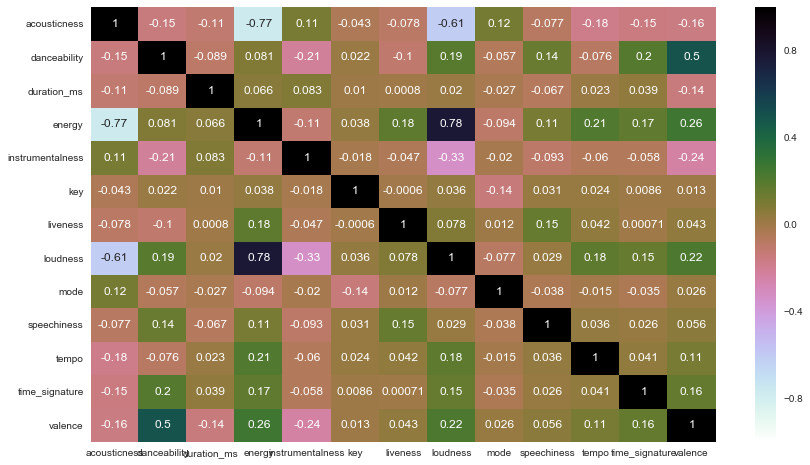

In [9]:
# Pearson Correlation map
# Looking for linear correlation between features (is there multicollinearity?)

plt.figure(figsize=(14,8)) 
sns.heatmap(features_df.corr(),annot=True,cmap='cubehelix_r') 
plt.show()

In [10]:
# Possible multicollinearity between loudness and energy (linear relationship)
# Negative relationship between loudness-acousticness and energy-acousticness
# We are only checking the LINEAR RELATIONSHIP. 
# We can try deleting loudness and acousticness to minimise relation between independent variables

C:\Users\ignac\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\ignac\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


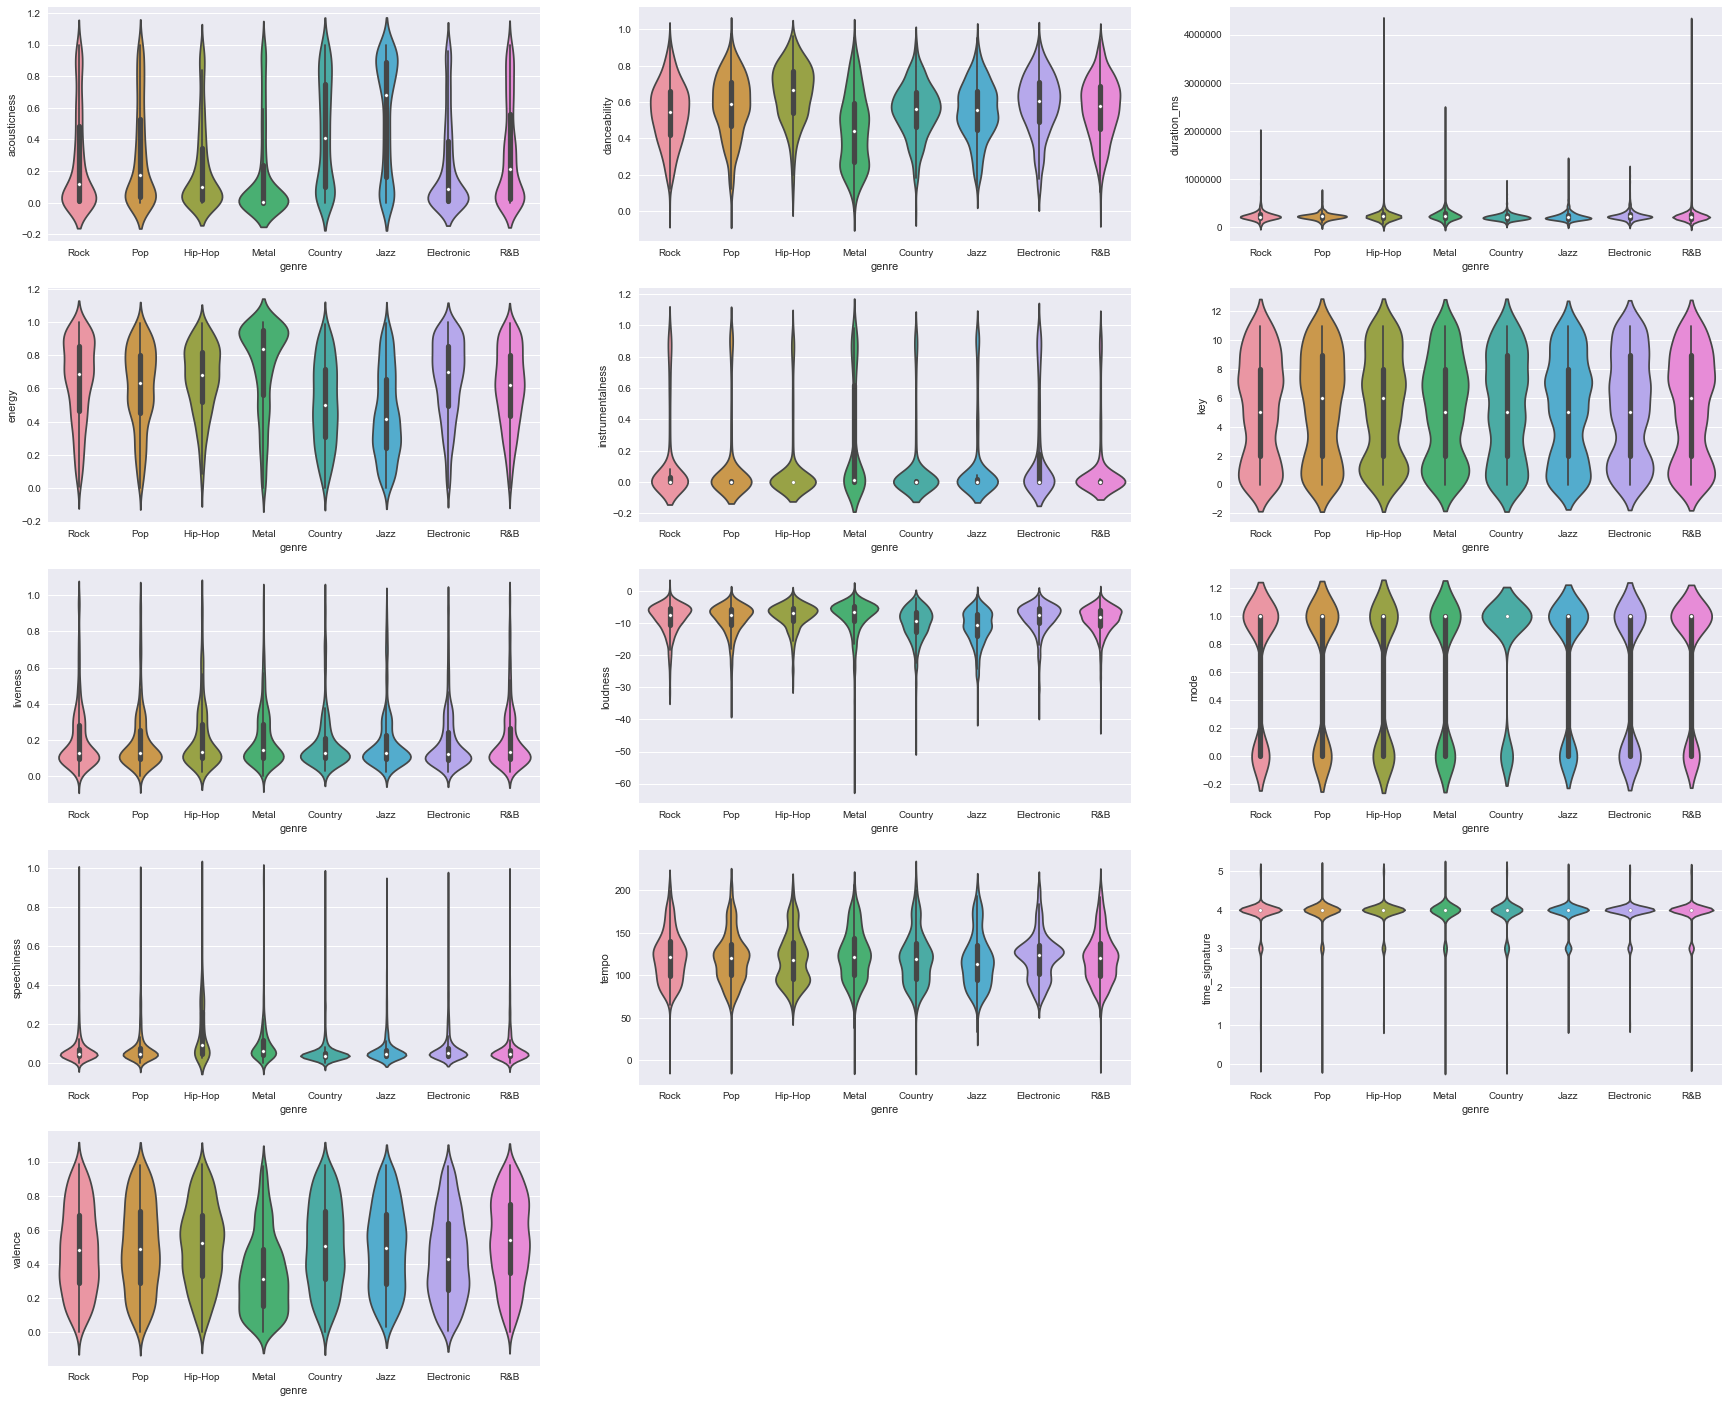

In [11]:
# Violin plot to find out more about the features

plt.figure(figsize=(30,25))

i = 1
for column in features_df.drop("genre", axis = 1):
    plt.subplot(5,3,i)
    sns.violinplot(x='genre', y=column, data=df)
    i = i + 1

plt.show()

In [12]:
# The first observation here is that there are no clear big difference in features between genres
# This brings to the assumption that the prediction won't be perform well

# These features were created by Spotify, we dont really now if they are accurate but we can check it here.
# Acousticness: Country and Jazz are more acoustic which sounds reasonable since they are known for performing unplugged
# Danceability: Metal genre is less danceable
# Metal is also more energetic, loud
# Liveness: Almost the same in all of them. Doesnt look useful because it indicates if the song is live, which none 
# of them are

# Metal has the biggest difference in almost all features but for the rest it will be difficult to find
# a clear differentiating line

In [13]:
# Drop liveness since it wont be useful
features_df = features_df.drop("liveness", axis=1)

In [14]:
# Feature importance with Random Forest Classifier

model= RandomForestClassifier(n_estimators=100,random_state=0)
X=features_df[features_df.columns[:-1]]
Y=features_df['genre']
model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

acousticness        0.121404
speechiness         0.110875
danceability        0.104629
energy              0.102705
valence             0.100950
duration_ms         0.098150
tempo               0.095872
loudness            0.095548
instrumentalness    0.079644
key                 0.062804
mode                0.016678
time_signature      0.010742
dtype: float64

# Prediction

In [15]:
def predict(algorithm, train_X, test_X, train_y):
    """ Fit algorithm, predict and get accuracy"""
    model = algorithm
    model.fit(train_X,train_y)
    prediction = model.predict(test_X)
    accuracy = metrics.accuracy_score(prediction,test_y)
    
    return accuracy  

In [16]:
# We start randomising the dataset to reduce variance
features_df_random = features_df.sample(frac=1)

In [ ]:
# Predict for all the features

X = features_df_random.drop("genre", axis = 1).values
y = features_df_random["genre"].values
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

accuracy_rf = []
accuracy_svc = []
accuracy_lr = []
accuracy_kn = []
accuracy_xgb = []

for train_index, test_index in kf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    accuracy_rf.append(predict(RandomForestClassifier(n_estimators = 100), train_X, test_X, train_y))
 
    accuracy_svc.append(predict(svm.SVC(gamma = "auto"), train_X, test_X, train_y))
    
    accuracy_lr.append(predict(LogisticRegression(solver = "lbfgs", multi_class = "auto"), train_X, test_X, train_y))
   
    accuracy_kn.append(predict(KNeighborsClassifier(n_neighbors=3), train_X, test_X, train_y))
    
    accuracy_xgb.append(predict(XGBClassifier(), train_X, test_X, train_y))
    

print('The accuracy of the Random Forest is', mean(accuracy_rf))
print('The accuracy of the SVM is:', mean(accuracy_svc))
print('The accuracy of the Logistic Regression is', mean(accuracy_lr))
print('The accuracy of the KNN is', mean(accuracy_kn))
print('The accuracy of the XGBoost is', mean(accuracy_xgb))

In [ ]:
# Predict for normalised features

X = features_df_norm.drop(["genre"], axis = 1).values
y = features_df_norm["genre"].values
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

accuracy_rf = []
accuracy_svc = []
accuracy_lr = []
accuracy_kn = []
accuracy_xgb = []

for train_index, test_index in kf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    accuracy_rf.append(predict(RandomForestClassifier(n_estimators = 100), train_X, test_X, train_y))
 
    accuracy_svc.append(predict(svm.SVC(gamma = "auto"), train_X, test_X, train_y))
    
    accuracy_lr.append(predict(LogisticRegression(solver = "lbfgs", multi_class = "auto"), train_X, test_X, train_y))
   
    accuracy_kn.append(predict(KNeighborsClassifier(n_neighbors=3), train_X, test_X, train_y))
    
    accuracy_xgb.append(predict(XGBClassifier(), train_X, test_X, train_y))
    

print('The accuracy of the Random Forest is', mean(accuracy_rf))
print('The accuracy of the SVM is:', mean(accuracy_svc))
print('The accuracy of the Logistic Regression is', mean(accuracy_lr))
print('The accuracy of the KNN is', mean(accuracy_kn))
print('The accuracy of the XGBoost is', mean(accuracy_xgb))

In [ ]:
# Predict for top5 features selected by Random Forest feature selector

X = features_df_random[["acousticness", "speechiness", "danceability", "energy", "valence"]].values
y = features_df_random["genre"].values
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

accuracy_rf = []
accuracy_svc = []
accuracy_lr = []
accuracy_kn = []
accuracy_xgb = []

for train_index, test_index in kf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    accuracy_rf.append(predict(RandomForestClassifier(n_estimators = 100), train_X, test_X, train_y))
 
    accuracy_svc.append(predict(svm.SVC(gamma = "auto"), train_X, test_X, train_y))
    
    accuracy_lr.append(predict(LogisticRegression(solver = "lbfgs", multi_class = "auto"), train_X, test_X, train_y))
   
    accuracy_kn.append(predict(KNeighborsClassifier(n_neighbors=3), train_X, test_X, train_y))
    
    accuracy_xgb.append(predict(XGBClassifier(), train_X, test_X, train_y))
    

print('The accuracy of the Random Forest is', mean(accuracy_rf))
print('The accuracy of the SVM is:', mean(accuracy_svc))
print('The accuracy of the Logistic Regression is', mean(accuracy_lr))
print('The accuracy of the KNN is', mean(accuracy_kn))
print('The accuracy of the XGBoost is', mean(accuracy_xgb))

In [ ]:
# Predict dropping features that could create multicollinearity according to the correlation map

X = features_df_random.drop(["genre", "loudness", "energy"], axis = 1).values
y = features_df_random["genre"].values
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

accuracy_rf = []
accuracy_svc = []
accuracy_lr = []
accuracy_kn = []
accuracy_xgb = []

for train_index, test_index in kf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    accuracy_rf.append(predict(RandomForestClassifier(n_estimators = 100), train_X, test_X, train_y))
 
    accuracy_svc.append(predict(svm.SVC(gamma = "auto"), train_X, test_X, train_y))
    
    accuracy_lr.append(predict(LogisticRegression(solver = "lbfgs", multi_class = "auto"), train_X, test_X, train_y))
   
    accuracy_kn.append(predict(KNeighborsClassifier(n_neighbors=3), train_X, test_X, train_y))
    
    accuracy_xgb.append(predict(XGBClassifier(), train_X, test_X, train_y))
    

print('The accuracy of the Random Forest is', mean(accuracy_rf))
print('The accuracy of the SVM is:', mean(accuracy_svc))
print('The accuracy of the Logistic Regression is', mean(accuracy_lr))
print('The accuracy of the KNN is', mean(accuracy_kn))
print('The accuracy of the XGBoost is', mean(accuracy_xgb))

In [17]:
# Apply one hot encoding to categorical variables

key_ohe = pd.get_dummies(list(features_df_random["key"].values), prefix= "key")
mode_ohe = pd.get_dummies(list(features_df_random["mode"].values), prefix= "mode")
time_signature_ohe = pd.get_dummies(list(features_df_random["time_signature"].values), prefix= "time_signature")

features_df_ohe = features_df_random.copy()
features_df_ohe = features_df_ohe.drop(["key", "mode", "time_signature"], axis = 1)
features_df_ohe = features_df_ohe.join(key_ohe)
features_df_ohe = features_df_ohe.join(mode_ohe)
features_df_ohe = features_df_ohe.join(time_signature_ohe)

In [18]:
features_df_ohe.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,genre,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
294,0.372000,0.565,197493,0.172,0.000003,-17.835,0.0311,82.281,0.462,Rock,...,0,0,1,1,0,0,0,0,1,0
3610,0.371000,0.695,245440,0.494,0.000004,-11.643,0.0263,108.588,0.453,Country,...,0,0,0,0,1,0,0,1,0,0
6035,0.023400,0.228,279860,0.864,0.000009,-5.278,0.2370,181.738,0.235,Electronic,...,0,1,0,1,0,0,0,0,1,0
7128,0.000275,0.183,202495,0.953,0.013400,-5.295,0.0778,94.371,0.494,R&B,...,0,0,1,1,0,0,0,0,1,0
3830,0.006600,0.472,228133,0.273,0.839000,-16.003,0.0319,70.051,0.625,Country,...,0,0,0,1,0,0,0,0,1,0


In [19]:
# Predict for all features and using one hot encoding

X = features_df_ohe.drop(["genre"], axis = 1).values
y = features_df_ohe["genre"].values
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

accuracy_rf = []
accuracy_svc = []
accuracy_lr = []
accuracy_kn = []
accuracy_xgb = []

for train_index, test_index in kf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    accuracy_rf.append(predict(RandomForestClassifier(n_estimators = 100), train_X, test_X, train_y))
 
    accuracy_svc.append(predict(svm.SVC(gamma = "auto"), train_X, test_X, train_y))
    
    accuracy_lr.append(predict(LogisticRegression(solver = "lbfgs", multi_class = "auto"), train_X, test_X, train_y))
   
    accuracy_kn.append(predict(KNeighborsClassifier(n_neighbors=3), train_X, test_X, train_y))
    
    accuracy_xgb.append(predict(XGBClassifier(), train_X, test_X, train_y))
    

print('The accuracy of the Random Forest is', mean(accuracy_rf))
print('The accuracy of the SVM is:', mean(accuracy_svc))
print('The accuracy of the Logistic Regression is', mean(accuracy_lr))
print('The accuracy of the KNN is', mean(accuracy_kn))
print('The accuracy of the XGBoost is', mean(accuracy_xgb))

The accuracy of the Random Forest is 0.4017087972888858
The accuracy of the SVM is: 0.28021232450376926
The accuracy of the Logistic Regression is 0.15029445328169305
The accuracy of the KNN is 0.20657583511999447
The accuracy of the XGBoost is 0.31978560066394635
